In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# Define parameters
im_height = 100
im_width = 100
batch_size = 32

# Define data path
data_path = "../gtsrb-german-traffic-sign/versions/1/"

In [ ]:
# Define CSV file path
data_path = "../gtsrb-german-traffic-sign/versions/1/"
csv_file = data_path + "whichSpeed.csv" 

# Load the CSV file
df = pd.read_csv(csv_file)

df['FullPath'] = data_path + df['Path']

# Extract arrays for file paths, ROI coordinates, and labels
paths = df['FullPath'].values
roi_x1 = df['Roi.X1'].values.astype(np.int32)
roi_y1 = df['Roi.Y1'].values.astype(np.int32)
roi_x2 = df['Roi.X2'].values.astype(np.int32)
roi_y2 = df['Roi.Y2'].values.astype(np.int32)
labels = df['ClassId'].values

# Create a tf.data.Dataset from these arrays
dataset = tf.data.Dataset.from_tensor_slices((paths, roi_x1, roi_y1, roi_x2, roi_y2, labels))

# Function to load an image, crop it based on ROI, resize, and normalize
def load_and_crop_image(path, x1, y1, x2, y2, label):
    # Read and decode the image file
    image_data = tf.io.read_file(path)
    img = tf.image.decode_image(image_data, channels=3)
    
    # Ensure ROI coordinates are integers
    x1 = tf.cast(x1, tf.int32)
    y1 = tf.cast(y1, tf.int32)
    x2 = tf.cast(x2, tf.int32)
    y2 = tf.cast(y2, tf.int32)
    
    # Compute crop dimensions
    crop_width = x2 - x1
    crop_height = y2 - y1
    
    # Crop the image to the ROI. Note: crop_to_bounding_box expects (offset_height, offset_width, height, width)
    cropped = tf.image.crop_to_bounding_box(img, offset_height=y1, offset_width=x1,
                                            target_height=crop_height, target_width=crop_width)
    
    # Resize the cropped image to the model's input size
    resized = tf.image.resize(cropped, [im_height, im_width])
    
    # Normalize pixel values to [0,1]
    normalized = resized / 255.0
    return normalized, label

# Map the load_and_crop_image function to the dataset
dataset = dataset.map(load_and_crop_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the dataset and split into training (80%) and validation (20%)
dataset_size = len(paths)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

dataset = dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=True)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# Batch and prefetch for performance
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load the VGG16 base model without the classification head
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, 
                                         input_shape=(im_height, im_width, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Custom classification model on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(9, activation='softmax')  # 9 output neurons for multi-class classification
])

# Compile the model with sparse categorical crossentropy loss for integer labels (0-8)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_whichSpeed_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=callbacks
)

Epoch 1/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.5258 - loss: 1.4437 - val_accuracy: 0.7894 - val_loss: 0.5953
Epoch 2/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.7913 - loss: 0.6097 - val_accuracy: 0.7924 - val_loss: 0.5723
Epoch 3/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 326s 967ms/step - accuracy: 0.8408 - loss: 0.4514 - val_accuracy: 0.8644 - val_loss: 0.3829
Epoch 4/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 323s 967ms/step - accuracy: 0.8578 - loss: 0.4096 - val_accuracy: 0.8871 - val_loss: 0.3169
Epoch 5/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 330s 989ms/step - accuracy: 0.8832 - loss: 0.3408 - val_accuracy: 0.8814 - val_loss: 0.3105
Epoch 6/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 324s 970ms/step - accuracy: 0.8901 - loss: 0.3152 - val_accuracy: 0.9129 - val_loss: 0.2481


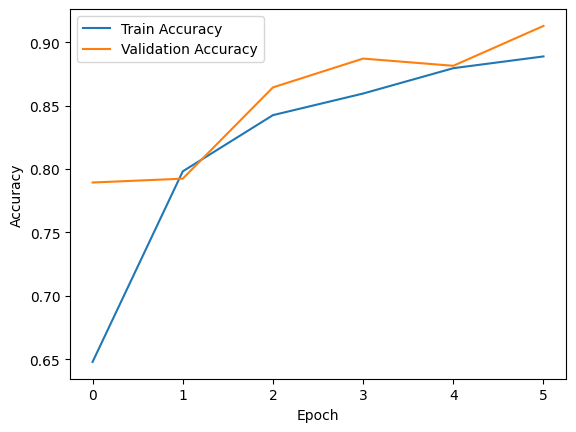

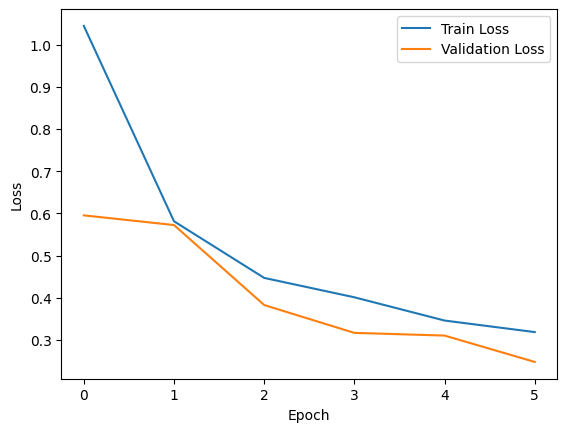

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
csv_file_test = data_path + "whichSpeed_test.csv"

# Load the CSV file
df_test = pd.read_csv(csv_file_test)

# Prepend the base directory to the relative image paths
df_test['FullPath'] = data_path + df_test['Path']

# Extract arrays for file paths, ROI coordinates, and labels
paths = df_test['FullPath'].values
roi_x1 = df_test['Roi.X1'].values.astype(np.int32)
roi_y1 = df_test['Roi.Y1'].values.astype(np.int32)
roi_x2 = df_test['Roi.X2'].values.astype(np.int32)
roi_y2 = df_test['Roi.Y2'].values.astype(np.int32)
labels = df_test['ClassId'].values

# Create a tf.data.Dataset from these arrays
dataset_test = tf.data.Dataset.from_tensor_slices((paths, roi_x1, roi_y1, roi_x2, roi_y2, labels))

# Map the custom function to the dataset
test_ds = dataset_test.map(load_and_crop_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch for performance
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

413/413 ━━━━━━━━━━━━━━━━━━━━ 302s 731ms/step - accuracy: 0.9441 - loss: 0.1655
Test Accuracy: 0.91


In [ ]:
# Mapping from class number to actual sign label
mapping = {
    0: "20",
    1: "30",
    2: "50",
    3: "60",
    4: "70",
    5: "80",
    6: "End Of Limit",
    7: "100",
    8: "120",
}

In [ ]:
# Gather true labels from the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate prediction probabilities using the model
y_pred_probs = model.predict(test_ds)

# Convert prediction probabilities to predicted class labels (using argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

413/413 ━━━━━━━━━━━━━━━━━━━━ 332s 804ms/step


Confusion Matrix:
[[ 204    4    0    2    0    0    0    0    0]
 [   0 2158    8    1   34   12    2    3    2]
 [   0    6 2122    2   66   18    1   35    0]
 [   0    3   17 1200  143   11    0   32    4]
 [   0    3    0    0 1965    2    0   10    0]
 [   0   22   60    5  104 1479    3  139   48]
 [   0    0    0    0    0    0  420    0    0]
 [   0    0    1    0   18    1    0 1419    1]
 [   0    0    4    0   84    3    3  235 1081]]

Classification Report:
              precision    recall  f1-score   support

          20       1.00      0.97      0.99       210
          30       0.98      0.97      0.98      2220
          50       0.96      0.94      0.95      2250
          70       0.99      0.85      0.92      1410
          80       0.81      0.99      0.89      1980
          90       0.97      0.80      0.87      1860
End Of Limit       0.98      1.00      0.99       420
         100       0.76      0.99      0.86      1440
         120       0.95      0.77     

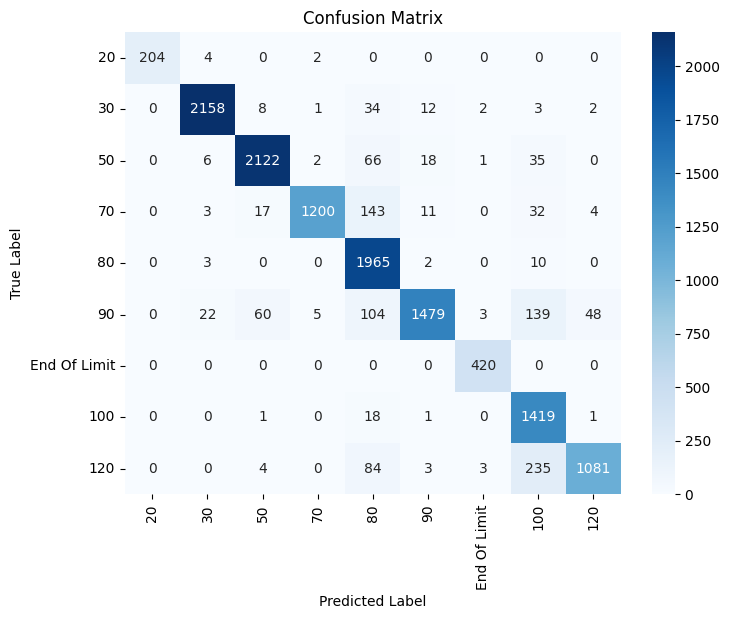

In [12]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

target_names = [mapping[i] for i in range(9)]

# Print a classification report with the mapped class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model = tf.keras.models.load_model('../modelsROI/best_whichSpeed_model.keras')
batch_size=32

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted sign: 20


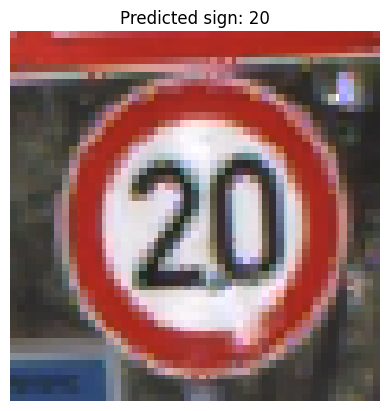

In [ ]:
# Path to image file
# img_path = "../gtsrb-german-traffic-sign/versions/1/Meta/7.png"
# img_path = "./whichSpeed_dataset_test//0/00000_00000_00020.png"
# img_path = "./whichSpeed_dataset_test//1/00001_00000_00020.png"
# img_path = "./whichSpeed_dataset_test//2/00002_00000_00020.png"
img_path = "./whichSpeed_dataset_test//0/00000_00000_00020.png"

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0, 1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_probs = model.predict(img_batch)[0]  # shape should be (9,) for 9 classes

# Convert prediction probabilities to a predicted class label using argmax
predicted_class = np.argmax(prediction_probs)
predicted_sign = mapping[predicted_class]
print("Predicted sign:", predicted_sign)
result = f"Predicted sign: {predicted_sign}"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()

ROI coordinates: 5 5 43 44


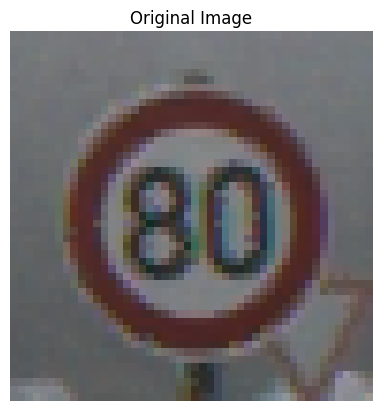

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted sign: 80


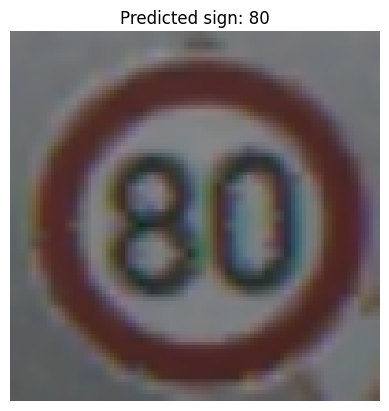

In [ ]:
# Load the CSV file
csv_file = data_path + "whichSpeed_test.csv"
df = pd.read_csv(csv_file)

df['FullPath'] = data_path + df['Path']

# Function to get ROI coordinates from the CSV for a given image path
def get_roi_for_image(image_path, df):
    # Look up the row matching the full image path
    row = df[df['FullPath'] == image_path]
    if row.empty:
        print("No ROI found for image:", image_path)
        return None
    else:
        roi_x1 = int(row['Roi.X1'].values[0])
        roi_y1 = int(row['Roi.Y1'].values[0])
        roi_x2 = int(row['Roi.X2'].values[0])
        roi_y2 = int(row['Roi.Y2'].values[0])
        return roi_x1, roi_y1, roi_x2, roi_y2

# Specify the image path
test_img_path = data_path + "Train/5/00005_00000_00020.png" 

# Retrieve ROI coordinates for this image from the CSV
roi = get_roi_for_image(test_img_path, df)
if roi is None:
    raise ValueError("Could not find ROI for the provided image path.")
else:
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    print("ROI coordinates:", roi_x1, roi_y1, roi_x2, roi_y2)

# Load the original image (without resizing)
img = image.load_img(test_img_path)
img_array = image.img_to_array(img)

# Display the original image
plt.imshow(img_array.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Crop the image using the ROI coordinates
cropped = tf.image.crop_to_bounding_box(
    img_array,
    offset_height=roi_y1,
    offset_width=roi_x1,
    target_height=roi_y2 - roi_y1,
    target_width=roi_x2 - roi_x1
)

# Resize the cropped ROI to the model's input size (100x100)
resized = tf.image.resize(cropped, [im_height, im_width])

# Normalize the image (scale pixel values to [0,1])
normalized = resized / 255.0

# Add a batch dimension (model expects a batch)
img_batch = np.expand_dims(normalized, axis=0)

#  Make a prediction
prediction_probs = model.predict(img_batch)[0]
predicted_class = np.argmax(prediction_probs)
predicted_sign = mapping.get(predicted_class, "Unknown") 
print("Predicted sign:", predicted_sign)

# For display, convert normalized image back to 0-255 range
display_img = tf.cast(normalized * 255.0, tf.uint8).numpy()

plt.imshow(display_img)
plt.title(f"Predicted sign: {predicted_sign}")
plt.axis("off")
plt.show()
